# Purpose
The purpose of this notebook is to emulate the SMS (semi-local momentum space) chiral potential using the NVP and KVP emulators. The potential has units of fm.

# Notebook Setup

## Importing Python libraries

In [1]:
import numpy as np
from numpy.typing import ArrayLike
from typing import Union, Optional
from ruamel.yaml import YAML
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py

%matplotlib inline
%load_ext autoreload    
%autoreload 2

## Importing local libraries

In [2]:
from emulate_kvp import setup_rc_params, plot_results
from emulate_kvp import plot_cross_section
from emulate_kvp import compute_errors
from emulate_kvp.utils import compute_mixed_S
from emulate_kvp.plots import plot_errors_spikes

from emulate_kvp import LHS_setup
from emulate_kvp import KVP_emulator
from emulate_kvp import Observables
from emulate_kvp import EmulateCrossSection

from emulate_nvp import BoundaryCondition
from emulate_nvp import ScatteringSystem
from emulate_nvp import TwoBodyScattering as NVP_emulator
from emulate_nvp import ObservablesEmulator

# Emulator setup

## Parameters

In [3]:
### PLOTTING ###
setup_rc_params(dpi=800)

### LHS PARAMETERS ###
mult_factor = 2 # Used to basis size: mult_factor * len(lecs) per partial wave
num_test = 500 # Size of testing arrays for emulator
vary_params = [-5, 5] # Range used for sampling parameter sets

### EMULATOR PARAMETERS ###
inc_param = False # If True, includes testing parameter set in training portion
emu_method = 'K' # Boundary conditions for emulator: 'K', '1/K', 'T', 'S', 'all'
solver = 'lstsq' # How to solve for prediction: 'lstsq', 'solve', 'pinv'
nugget = 1e-10 # Nugget for emulator calculations
seed = 1 # Random number seed for reproducibility

## Unpack potentials from h5 file for training

In [4]:
file_name = '../data/SMS_n4lo+_Lambda450MeV_jmax-20_np_5_036_402020.h5'

with h5py.File(file_name, "r") as f:
    jmax = int(f['jmax'][...])
    chiral_order = int(f['chiral_order'][...])
    cutoff = int(f['cutoff'][...])
    interaction = str(f['interaction'][...])[2:-1]
    
    E = f['E'][...]
    k = f['k'][...]
    degrees = f['degrees'][...]
    ps = f['ps'][...]
    ws = f['ws'][...]
    mesh_nodes = f['mesh_nodes'][...]
    pts_per_region = f['pts_per_region'][...]
    
    V_1S0 = f['V_1S0'][...]
    V0_1S0 = f['V0_1S0'][...]
    V1_1S0 = f['V1_1S0'][...]
    V_3P0 = f['V_3P0'][...]
    V0_3P0 = f['V0_3P0'][...]
    V1_3P0 = f['V1_3P0'][...]
    V_1P1 = f['V_1P1'][...]
    V0_1P1 = f['V0_1P1'][...]
    V1_1P1 = f['V1_1P1'][...]
    V_3P1 = f['V_3P1'][...]
    V0_3P1 = f['V0_3P1'][...]
    V1_3P1 = f['V1_3P1'][...]
    V_1D2 = f['V_1D2'][...]
    V0_1D2 = f['V0_1D2'][...]
    V1_1D2 = f['V1_1D2'][...]
    V_3D2 = f['V_3D2'][...]
    V0_3D2 = f['V0_3D2'][...]
    V1_3D2 = f['V1_3D2'][...]
    V_1F3 = f['V_1F3'][...]
    V0_1F3 = f['V0_1F3'][...]
    V1_1F3 = f['V1_1F3'][...]
    V_3F3 = f['V_3F3'][...]
    V0_3F3 = f['V0_3F3'][...]
    V1_3F3 = f['V1_3F3'][...]
    V_1 = f['V_1'][...]
    V_2 = f['V_2'][...]
    V_3S1_3D1 = f['V_3S1_3D1'][...]
    V0_3S1_3D1 = f['V0_3S1_3D1'][...]
    V1_3S1_3D1 = f['V1_3S1_3D1'][...]
    V_3P2_3F2 = f['V_3P2_3F2'][...]
    V0_3P2_3F2 = f['V0_3P2_3F2'][...]
    V1_3P2_3F2 = f['V1_3P2_3F2'][...]
    V_3D3_3G3 = f['V_3D3_3G3'][...]
    V0_3D3_3G3 = f['V0_3D3_3G3'][...]
    V1_3D3_3G3 = f['V1_3D3_3G3'][...]
    V_3F4_3H4 = f['V_3F4_3H4'][...]
    V0_3F4_3H4 = f['V0_3F4_3H4'][...]
    V1_3F4_3H4 = f['V1_3F4_3H4'][...]
    V_no_contacts = f['V_no_contacts'][...]

In [5]:
V_no_contacts_reshape = np.reshape(V_no_contacts, 
                                  (int(V_no_contacts.shape[0] / 6), 
                                   6, 
                                   V_no_contacts.shape[2], 
                                   V_no_contacts.shape[3], 
                                   V_no_contacts.shape[4]))

In [6]:
### MESH PARAMETERS ###
ki = mesh_nodes[0] # Mesh initial point
cut_reg1 = mesh_nodes[1] # Mesh cutoff of first region
cut_reg2 = mesh_nodes[2] # Mesh cutoff of second region
kf = mesh_nodes[3] # Mesh cutoff

pts_reg1 = pts_per_region[0] # Total points in first region
pts_reg2 = pts_per_region[1] # Total points in second region
pts_reg3 = pts_per_region[2] # Total points in third region
Ntot = pts_reg1 + pts_reg2 + pts_reg3 # Total mesh size

## Get coupling constants from YAML file

In [7]:
if (cutoff == 1):
    value = 400
elif (cutoff == 2):
    value = 450
elif (cutoff == 3):
    value = 500
elif (cutoff == 4):
    value = 550
    
location = '../data/' + str(value) + 'MeV/'

yaml = YAML(typ="safe")
with open(location + 'sms_lecs_n4lop_lam' + str(value) + '.yaml', "r") as input_file:
    lecs_yaml = yaml.load(input_file)

In [8]:
lecs_1S0 = [val for key, val in lecs_yaml.items() if "1S0" in key]
lecs_3P0 = [val for key, val in lecs_yaml.items() if "3P0" in key]
lecs_1P1 = [val for key, val in lecs_yaml.items() if "1P1" in key]
lecs_3P1 = [val for key, val in lecs_yaml.items() if "3P1" in key]
lecs_1D2 = [val for key, val in lecs_yaml.items() if "1D2" in key]
lecs_3D2 = [val for key, val in lecs_yaml.items() if "3D2" in key]
lecs_1F3 = [val for key, val in lecs_yaml.items() if "1F3" in key]
lecs_3F3 = [val for key, val in lecs_yaml.items() if "3F3" in key]

lecs_3S1_3D1 = [val for key, val in lecs_yaml.items() if "3S1" in key or "3D1" in key]
lecs_3P2_3F2 = [val for key, val in lecs_yaml.items() if "3P2" in key or "3F2" in key]
lecs_3D3_3G3 = [val for key, val in lecs_yaml.items() if "3D3" in key or "3G3" in key]
lecs_3F4_3H4 = [val for key, val in lecs_yaml.items() if "3F4" in key or "3H4" in key]

# Emulator calculation

## Uncoupled channels

### Partial wave: 1S0

In [9]:
jmom, wave = 0, '1S0'
n_b_1S0 = mult_factor * len(lecs_1S0)

basis_1S0 = LHS_setup(lecs_1S0, vary_params, n_b_1S0, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_1S0 = KVP_emulator(k, ps, ws, V0_1S0, V1_1S0, wave, is_coupled=False)
emu_1S0.train(basis_1S0, glockle=True, method=emu_method)
emu_pred_glockle_1S0 = emu_1S0.prediction(lecs_1S0, glockle=True, 
                                          sol=solver, h=nugget)

emu_1S0.train(basis_1S0, glockle=False, method=emu_method)
emu_pred_std_1S0 = emu_1S0.prediction(lecs_1S0, glockle=False, 
                                      sol=solver, h=nugget)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
scatt_1S0 = NVP_emulator(
    V0=2 / np.pi * V0_1S0,
    V1=2 / np.pi * V1_1S0,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_1S0.fit(basis_1S0);

### Partial wave: 3P0

In [11]:
jmom, wave = 0, '3P0'
n_b_3P0 = mult_factor * len(lecs_3P0)

basis_3P0 = LHS_setup(lecs_3P0, vary_params, n_b_3P0, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_3P0 = KVP_emulator(k, ps, ws, V0_3P0, V1_3P0, wave, is_coupled=False)
emu_3P0.train(basis_3P0, glockle=True, method=emu_method)
emu_3P0.train(basis_3P0, glockle=False, method=emu_method)

In [12]:
scatt_3P0 = NVP_emulator(
    V0=2 / np.pi * V0_3P0,
    V1=2 / np.pi * V1_3P0,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_3P0.fit(basis_3P0);

### Partial wave: 1P1

In [13]:
jmom, wave = 1, '1P1'
n_b_1P1 = mult_factor * len(lecs_1P1)

basis_1P1 = LHS_setup(lecs_1P1, vary_params, n_b_1P1, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_1P1 = KVP_emulator(k, ps, ws, V0_1P1, V1_1P1, wave, is_coupled=False)
emu_1P1.train(basis_1P1, glockle=True, method=emu_method)
emu_1P1.train(basis_1P1, glockle=False, method=emu_method)

In [14]:
scatt_1P1 = NVP_emulator(
    V0=2 / np.pi * V0_1P1,
    V1=2 / np.pi * V1_1P1,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_1P1.fit(basis_1P1);

### Partial wave: 3P1

In [15]:
jmom, wave = 1, '3P1'
n_b_3P1 = mult_factor * len(lecs_3P1)

basis_3P1 = LHS_setup(lecs_3P1, vary_params, n_b_3P1, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_3P1 = KVP_emulator(k, ps, ws, V0_3P1, V1_3P1, wave, is_coupled=False)
emu_3P1.train(basis_3P1, glockle=True, method=emu_method)
emu_3P1.train(basis_3P1, glockle=False, method=emu_method)

In [16]:
scatt_3P1 = NVP_emulator(
    V0=2 / np.pi * V0_3P1,
    V1=2 / np.pi * V1_3P1,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_3P1.fit(basis_3P1);

### Partial wave: 1D2

In [17]:
jmom, wave = 2, '1D2'
n_b_1D2 = mult_factor * len(lecs_1D2)

basis_1D2 = LHS_setup(lecs_1D2, vary_params, n_b_1D2, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_1D2 = KVP_emulator(k, ps, ws, V0_1D2, V1_1D2, wave, is_coupled=False)
emu_1D2.train(basis_1D2, glockle=True, method=emu_method)
emu_1D2.train(basis_1D2, glockle=False, method=emu_method)

In [18]:
scatt_1D2 = NVP_emulator(
    V0=2 / np.pi * V0_1D2,
    V1=2 / np.pi * V1_1D2,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_1D2.fit(basis_1D2);

### Partial wave: 3D2

In [19]:
jmom, wave = 2, '3D2'
n_b_3D2 = mult_factor * len(lecs_3D2)

basis_3D2 = LHS_setup(lecs_3D2, vary_params, n_b_3D2, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_3D2 = KVP_emulator(k, ps, ws, V0_3D2, V1_3D2, wave, is_coupled=False)
emu_3D2.train(basis_3D2, glockle=True, method=emu_method)
emu_3D2.train(basis_3D2, glockle=False, method=emu_method)

In [20]:
scatt_3D2 = NVP_emulator(
    V0=2 / np.pi * V0_3D2,
    V1=2 / np.pi * V1_3D2,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_3D2.fit(basis_3D2);

### Partial wave: 1F3

In [21]:
jmom, wave = 3, '1F3'
n_b_1F3 = mult_factor * len(lecs_1F3)

basis_1F3 = LHS_setup(lecs_1F3, vary_params, n_b_1F3, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_1F3 = KVP_emulator(k, ps, ws, V0_1F3, V1_1F3, wave, is_coupled=False)
emu_1F3.train(basis_1F3, glockle=True, method=emu_method)
emu_1F3.train(basis_1F3, glockle=False, method=emu_method)

In [22]:
scatt_1F3 = NVP_emulator(
    V0=2 / np.pi * V0_1F3,
    V1=2 / np.pi * V1_1F3,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_1F3.fit(basis_1F3);

### Partial wave: 3F3

In [23]:
jmom, wave = 3, '3F3'
n_b_3F3 = mult_factor * len(lecs_3F3)

basis_3F3 = LHS_setup(lecs_3F3, vary_params, n_b_3F3, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_3F3 = KVP_emulator(k, ps, ws, V0_3F3, V1_3F3, wave, is_coupled=False)
emu_3F3.train(basis_3F3, glockle=True, method=emu_method)
emu_3F3.train(basis_3F3, glockle=False, method=emu_method)

In [24]:
scatt_3F3 = NVP_emulator(
    V0=2 / np.pi * V0_3F3,
    V1=2 / np.pi * V1_3F3,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_3F3.fit(basis_3F3);

## Coupled channels

### Partial wave: 3S1/3D1

In [25]:
jmom, wave = 1, '3S1/3D1'
n_b_3S1_3D1 = mult_factor * len(lecs_3S1_3D1)

basis_3S1_3D1 = LHS_setup(lecs_3S1_3D1, vary_params, n_b_3S1_3D1, num_test, 
                          inc_param=inc_param, fix_seed=seed)[0]

emu_3S1_3D1 = KVP_emulator(k, ps, ws, V0_3S1_3D1, V1_3S1_3D1, wave, is_coupled=True)
emu_3S1_3D1.train(basis_3S1_3D1, glockle=True, method=emu_method)
emu_3S1_3D1.train(basis_3S1_3D1, glockle=False, method=emu_method)

In [26]:
scatt_3S1_3D1 = NVP_emulator(
    V0=2 / np.pi * V0_3S1_3D1,
    V1=2 / np.pi * V1_3S1_3D1,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    is_coupled=True,
    nugget=nugget,
)
scatt_3S1_3D1.fit(basis_3S1_3D1);

### Partial wave: 3P2/3F2

In [27]:
jmom, wave = 2, '3P2/3F2'
n_b_3P2_3F2 = mult_factor * len(lecs_3P2_3F2)

basis_3P2_3F2 = LHS_setup(lecs_3P2_3F2, vary_params, n_b_3P2_3F2, num_test, 
                          inc_param=inc_param, fix_seed=seed)[0]

emu_3P2_3F2 = KVP_emulator(k, ps, ws, V0_3P2_3F2, V1_3P2_3F2, wave, is_coupled=True)
emu_3P2_3F2.train(basis_3P2_3F2, glockle=True, method=emu_method)
emu_3P2_3F2.train(basis_3P2_3F2, glockle=False, method=emu_method)

In [28]:
scatt_3P2_3F2 = NVP_emulator(
    V0=2 / np.pi * V0_3P2_3F2,
    V1=2 / np.pi * V1_3P2_3F2,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    is_coupled=True,
    nugget=nugget,
)
scatt_3P2_3F2.fit(basis_3P2_3F2);

### Partial wave: 3D3/3G3

In [29]:
jmom, wave = 3, '3D3/3G3'
n_b_3D3_3G3 = mult_factor * len(lecs_3D3_3G3)

basis_3D3_3G3 = LHS_setup(lecs_3D3_3G3, vary_params, n_b_3D3_3G3, num_test, 
                          inc_param=inc_param, fix_seed=seed)[0]

emu_3D3_3G3 = KVP_emulator(k, ps, ws, V0_3D3_3G3, V1_3D3_3G3, wave, is_coupled=True)
emu_3D3_3G3.train(basis_3D3_3G3, glockle=True, method=emu_method)
emu_3D3_3G3.train(basis_3D3_3G3, glockle=False, method=emu_method)

In [30]:
scatt_3D3_3G3 = NVP_emulator(
    V0=2 / np.pi * V0_3D3_3G3,
    V1=2 / np.pi * V1_3D3_3G3,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    is_coupled=True,
    nugget=nugget,
)
scatt_3D3_3G3.fit(basis_3D3_3G3);

### Partial wave: 3F4/3H4

In [31]:
jmom, wave = 4, '3F4/3H4'
n_b_3F4_3H4 = mult_factor * len(lecs_3F4_3H4)

basis_3F4_3H4 = LHS_setup(lecs_3F4_3H4, vary_params, n_b_3F4_3H4, num_test, 
                          inc_param=inc_param, fix_seed=seed)[0]

emu_3F4_3H4 = KVP_emulator(k, ps, ws, V0_3F4_3H4, V1_3F4_3H4, wave, is_coupled=True)
emu_3F4_3H4.train(basis_3F4_3H4, glockle=True, method=emu_method)
emu_3F4_3H4.train(basis_3F4_3H4, glockle=False, method=emu_method)

In [32]:
scatt_3F4_3H4 = NVP_emulator(
    V0=2 / np.pi * V0_3F4_3H4,
    V1=2 / np.pi * V1_3F4_3H4,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    is_coupled=True,
    nugget=nugget,
)
scatt_3F4_3H4.fit(basis_3F4_3H4);

## Emulating the total cross section

### Getting KVP emulators

In [33]:
jmom, wave = 4, None

emu_1 = KVP_emulator(k, ps, ws, V_1, 0, wave, is_coupled=False)
emu_2 = KVP_emulator(k, ps, ws, V_2, 0, wave, is_coupled=False)

In [34]:
inputs_uncoupled = [
    [0, lecs_1S0, V_1S0, emu_1S0],
    [0, lecs_3P0, V_3P0, emu_3P0],
    [1, lecs_1P1, V_1P1, emu_1P1],
    [1, lecs_3P1, V_3P1, emu_3P1],
    [2, lecs_1D2, V_1D2, emu_1D2],
    [2, lecs_3D2, V_3D2, emu_3D2],
    [3, lecs_1F3, V_1F3, emu_1F3],
    [3, lecs_3F3, V_3F3, emu_3F3],
    [4, None, V_1, emu_1],
    [4, None, V_2, emu_2],
]

inputs_coupled = [
    [1, lecs_3S1_3D1, V_3S1_3D1, emu_3S1_3D1],
    [2, lecs_3P2_3F2, V_3P2_3F2, emu_3P2_3F2],
    [3, lecs_3D3_3G3, V_3D3_3G3, emu_3D3_3G3],
    [4, lecs_3F4_3H4, V_3F4_3H4, emu_3F4_3H4],
]

inputs_no_contacts = [
    [j + 5, 
     None, 
     V_no_contacts_reshape[j][idx], 
     KVP_emulator(k, ps, ws, V_no_contacts_reshape[j][idx], 0, None)
    ] 
    for j in range(jmax - 4) for idx in range(6)
]

inputs_all = inputs_uncoupled + inputs_coupled + inputs_no_contacts
js, lecs, potentials, emulators = list(zip(*inputs_all))

### Getting NVP emulators

In [35]:
scatt_1 = NVP_emulator(
    V0=2 / np.pi * V_1,
    V1=2 / np.pi * np.zeros_like(V_1[..., None]),
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)

scatt_2 = NVP_emulator(
    V0=2 / np.pi * V_2,
    V1=2 / np.pi * np.zeros_like(V_2[..., None]),
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)

In [36]:
inputs_uncoupled_nvp = [
    [0, lecs_1S0, scatt_1S0],
    [0, lecs_3P0, scatt_3P0],
    [1, lecs_1P1, scatt_1P1],
    [1, lecs_3P1, scatt_3P1],
    [2, lecs_1D2, scatt_1D2],
    [2, lecs_3D2, scatt_3D2],
    [3, lecs_1F3, scatt_1F3],
    [3, lecs_3F3, scatt_3F3],
    [4, None, scatt_1],
    [4, None, scatt_2],
]

inputs_coupled_nvp = [
    [1, lecs_3S1_3D1, scatt_3S1_3D1],
    [2, lecs_3P2_3F2, scatt_3P2_3F2],
    [3, lecs_3D3_3G3, scatt_3D3_3G3],
    [4, lecs_3F4_3H4, scatt_3F4_3H4],
]

inputs_no_contacts_nvp = [
    [j + 5, 
     None,  
     NVP_emulator(
        V0=2 / np.pi * V_no_contacts_reshape[j][idx],
        V1=2 / np.pi * np.zeros_like(V_no_contacts_reshape[j][idx][..., None]),
        k=ps, dk=ws, t_lab=E,
        system=ScatteringSystem(interaction),
        boundary_condition=BoundaryCondition.STANDING,
        nugget=nugget,
    )
    ] 
    for j in range(jmax - 4) for idx in range(6)
]

inputs_all_nvp = inputs_uncoupled_nvp + inputs_coupled_nvp + inputs_no_contacts_nvp

j_nvp, lecs_nvp, emulators_nvp = list(zip(*inputs_all_nvp))

### Getting LECs

In [37]:
true_lecs = lecs_1S0 +  lecs_3P0 + lecs_1P1 + \
            lecs_3P1 + lecs_1D2 + lecs_3D2 + \
            lecs_1F3 + lecs_3F3 + lecs_3S1_3D1 + \
            lecs_3P2_3F2 + lecs_3D3_3G3 + lecs_3F4_3H4

lec_test_all = LHS_setup(true_lecs, vary_params, 0, num_test, fix_seed=seed)[1]
true_lecs_arr = np.array(true_lecs)
print(lec_test_all.shape)

(500, 25)


## Total cross section emulation

In [38]:
compute_obs = Observables(E, k, degrees)
get_cs = EmulateCrossSection(js, lecs, emulators, solver)
nvp_obs = ObservablesEmulator(emulators_nvp, lecs_nvp, 
                              j_nvp, compute_obs)

### Total cross section - Simulator

In [39]:
%%time
cs_sim = get_cs.emulate_cross_section(true_lecs, potentials, nugget, 
                                      glockle=None, emulate=False, remove_kohn=False)

CPU times: user 47.2 s, sys: 2.17 s, total: 49.4 s
Wall time: 7.07 s


### Total cross section - KVP with Std

In [40]:
%%time
cs_emu_std = get_cs.emulate_cross_section(true_lecs, potentials, nugget, 
                                          glockle=False, emulate=True, remove_kohn=False)

CPU times: user 1.56 s, sys: 103 ms, total: 1.66 s
Wall time: 222 ms


### Total cross section - KVP with Glockle

In [41]:
%%time
cs_emu_glockle = get_cs.emulate_cross_section(true_lecs, potentials, nugget, 
                                              glockle=True, emulate=True, remove_kohn=False)

CPU times: user 1.47 s, sys: 68.1 ms, total: 1.54 s
Wall time: 198 ms


### Total cross section - NVP

In [42]:
%%time
cs_sim_nvp = nvp_obs.predict(true_lecs_arr, full_space=True)

CPU times: user 1min 4s, sys: 3.43 s, total: 1min 8s
Wall time: 9.56 s


In [43]:
%%time
cs_emu_nvp = nvp_obs.predict(true_lecs_arr, full_space=False)

CPU times: user 508 ms, sys: 35.8 ms, total: 543 ms
Wall time: 71 ms


In [44]:
cs_rel_err_std = compute_errors(cs_sim, cs_emu_std)[1]
cs_rel_err_glockle = compute_errors(cs_sim, cs_emu_glockle)[1]
cs_rel_err_nvp = compute_errors(cs_sim_nvp, cs_emu_nvp)[1]

if cs_rel_err_std.shape[0] == 1:
    cs_rel_err_std = np.squeeze(cs_rel_err_std)
    cs_rel_err_glockle = np.squeeze(cs_rel_err_glockle)
    cs_rel_err_nvp = np.squeeze(cs_rel_err_nvp)
else:
    cs_min_rel_err_std = np.minimum(cs_rel_err_std[0], cs_rel_err_std[1])
    cs_min_rel_err_glockle = np.minimum(cs_rel_err_glockle[0], cs_rel_err_glockle[1])
    cs_min_rel_err_nvp = np.minimum(cs_rel_err_nvp[0], cs_rel_err_nvp[1])

## Total cross section: predict with sampled parameter sets

In [45]:
cs_sim_sample = np.zeros((num_test, E.shape[0]))
cs_emu_std_sample = np.zeros((num_test, E.shape[0]))
cs_emu_glockle_sample = np.zeros((num_test, E.shape[0]))
cs_sim_nvp_sample = np.zeros((num_test, E.shape[0]))
cs_emu_nvp_sample = np.zeros((num_test, E.shape[0]))

### Sampled cross section - KVP emulator with Std

In [46]:
test_cs_emu_std = %timeit -c -o -n 1 -r 1 get_cs.predict(cs_emu_std_sample, lec_test_all, potentials, nugget, glockle=False, emulate=True, remove_kohn=False)


8min 21s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Sampled cross section - KVP emulator with Glockle

In [47]:
test_cs_emu_glockle = %timeit -c -o -n 1 -r 1 get_cs.predict(cs_emu_glockle_sample, lec_test_all, potentials, nugget, glockle=True, emulate=True, remove_kohn=False)


8min 15s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Sampled cross section - Simulator

In [48]:
test_cs_sim = %timeit -c -o -n 1 -r 1 get_cs.predict(cs_sim_sample, lec_test_all, potentials, nugget, glockle=None, emulate=False, remove_kohn=False)


1h 49min 35s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Sampled cross section - NVP

In [49]:
test_cs_emu_nvp = %timeit -c -o -n 1 -r 1 nvp_obs.predict(lec_test_all, full_space=False, out=cs_emu_nvp_sample)

2min 8s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [50]:
test_cs_sim_nvp = %timeit -c -o -n 1 -r 1 nvp_obs.predict(lec_test_all, full_space=True, out=cs_sim_nvp_sample)

1h 35min 50s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Sampled cross section - Timing

In [51]:
test_cs_sim.average / test_cs_emu_std.average

13.119576176136357

In [52]:
test_cs_sim.average / test_cs_emu_glockle.average

13.271943745640403

In [53]:
test_cs_sim_nvp.average / test_cs_emu_nvp.average

44.616321466577034

### Sampled cross section - Results

In [54]:
cs_rel_sample_std = compute_errors(cs_sim_sample, 
                                   cs_emu_std_sample)[1]
cs_rel_mean_std = np.mean(cs_rel_sample_std, axis=0)

cs_rel_sample_glockle = compute_errors(cs_sim_sample, 
                                       cs_emu_glockle_sample)[1]
cs_rel_mean_glockle = np.mean(cs_rel_sample_glockle, axis=0)

cs_rel_sample_nvp = compute_errors(cs_sim_nvp_sample, 
                                   cs_emu_nvp_sample)[1]
cs_rel_mean_nvp = np.mean(cs_rel_sample_nvp, axis=0)

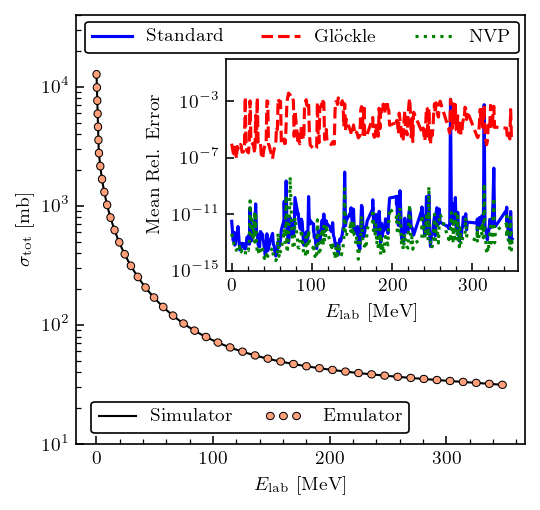

In [55]:
cs_errors = [cs_rel_mean_glockle, cs_rel_mean_std, cs_rel_mean_nvp]
plot_cross_section(E, value, jmax, cs_sim, cs_emu_std[0], cs_errors)

## Analyzing the Kohn anomalies and spikes: 1S0

In [56]:
file_name = '../data/SMS_n4lo+_Lambda450MeV_jmax-20_np_5_036_402020_spikes.h5'

with h5py.File(file_name, "r") as f:
    E_spikes = f['E'][...]
    k_spikes = f['k'][...]
    ps_spikes = f['ps'][...]
    ws_spikes = f['ws'][...]
    
    V0_1S0_spikes = f['V0_1S0'][...]
    V1_1S0_spikes = f['V1_1S0'][...]

In [57]:
emu_method_1S0 = 'all'
emu_method_1S0_spikes = '1/K'

jmom, wave = 0, '1S0'
n_b_1S0 = mult_factor * len(lecs_1S0) + 1

basis_1S0 = LHS_setup(lecs_1S0, vary_params, n_b_1S0, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]
emu_1S0 = KVP_emulator(k, ps, ws, V0_1S0, V1_1S0, wave, is_coupled=False)

In [58]:
emu_1S0.train(basis_1S0, glockle=True, method=emu_method_1S0)
emu_glockle = emu_1S0.prediction(lecs_1S0, glockle=True, 
                                 sol=solver, h=nugget)

emu_1S0.train(basis_1S0, glockle=False, method=emu_method_1S0)
emu_std = emu_1S0.prediction(lecs_1S0, glockle=False, 
                             sol=solver, h=nugget)

sim = emu_1S0.high_fidelity(lecs_1S0)

emu_glockle_mix = compute_mixed_S(emu_glockle)
emu_std_mix = compute_mixed_S(emu_std)

rel_err_glockle_fixed = abs((sim - emu_glockle_mix) / sim)
rel_err_std_fixed = abs((sim - emu_std_mix) / sim)

In [59]:
emu_1S0_spikes = KVP_emulator(k_spikes, ps_spikes, ws_spikes, V0_1S0_spikes, 
                              V1_1S0_spikes, wave, is_coupled=False)

emu_1S0_spikes.train(basis_1S0, glockle=True, method=emu_method_1S0_spikes)
emu_glockle_spikes = emu_1S0_spikes.prediction(lecs_1S0, glockle=True, 
                                               sol=solver, h=nugget)

emu_1S0_spikes.train(basis_1S0, glockle=False, method=emu_method_1S0_spikes)
emu_std_spikes = emu_1S0_spikes.prediction(lecs_1S0, glockle=False, 
                                           sol=solver, h=nugget)
sim_spikes = emu_1S0_spikes.high_fidelity(lecs_1S0)

rel_err_glockle = abs((sim_spikes - emu_glockle_spikes) / sim_spikes)[0]
rel_err_std = abs((sim_spikes - emu_std_spikes) / sim_spikes)[0]

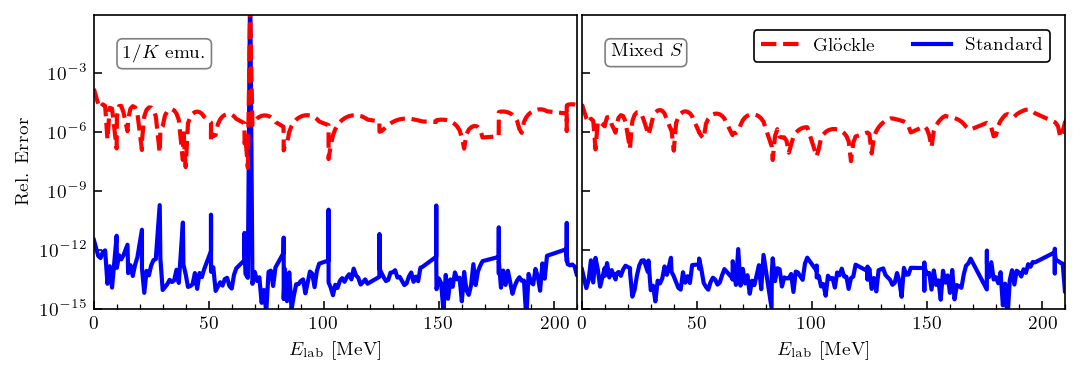

In [60]:
error_spikes = [rel_err_glockle, rel_err_std]
error_spikes_fixed = [rel_err_glockle_fixed, rel_err_std_fixed]

plot_errors_spikes(E, value, wave, error_spikes, error_spikes_fixed)